In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
data_path = "C:\\Users\\MartyNattakit\\Desktop\\CodeSentinel2025\\datasets\\cleaned\\cwe_top5_sampled_with_juliet_none.csv"
df = pd.read_csv(data_path)

# Check for NaN values
print("NaN Values per Column:")
print(df.isna().sum())

NaN Values per Column:
file       0
cwe        0
label    400
code       0
dtype: int64


In [18]:
# Clean data and map labels
label_map = {
    'none': 0,
    'cwe121': 1,
    'cwe78': 2,
    'cwe190': 3,
    'cwe191': 4,
    'cwe122': 5
}
df['label'] = df['cwe'].astype(str).str.strip().str.lower().map(label_map).fillna(0)
df = df.dropna()

In [19]:
duplicate_counts = df['code'].value_counts()
print("\nDuplicate Analysis:")
print(f"Total samples: {len(df)}")
print(f"Unique samples: {len(df['code'].unique())}")
print(f"Number of duplicate code snippets: {sum(duplicate_counts > 1)}")


Duplicate Analysis:
Total samples: 2400
Unique samples: 1730
Number of duplicate code snippets: 121


In [20]:
df_clean = df.dropna(subset=['label'])
df_clean = df_clean.drop_duplicates(subset=['code'])

In [21]:
# Visualization function
def visualize_data_quality(df, df_clean):
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 13))
    
    # 1. Original vs Clean Distribution
    df_counts = df['cwe'].value_counts().sort_index()
    df_clean_counts = df_clean['cwe'].value_counts().sort_index()
    x = np.arange(len(df_counts.index))
    width = 0.35
    
    axes[0,0].bar(x - width/2, df_counts, width, label='Original', color='skyblue')
    axes[0,0].bar(x + width/2, df_clean_counts, width, label='Clean', color='lightgreen')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(df_counts.index, rotation=45)
    axes[0,0].set_title('CWE Distribution: Original vs Clean', pad=20)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Duplicate Analysis by CWE
    duplicate_mask = df.duplicated(subset=['code'], keep=False)
    duplicates = df[duplicate_mask]
    dup_counts = duplicates['cwe'].value_counts()
    
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(dup_counts)))
    axes[0,1].pie(dup_counts, labels=dup_counts.index, autopct='%1.1f%%', 
                  colors=colors, startangle=90)
    axes[0,1].set_title('Distribution of Duplicates by CWE', pad=20)
    
    # 3. Cross-CWE Heatmap
    cross_cwe_matrix = pd.crosstab(
        duplicates['cwe'], 
        duplicates['cwe'],
        values=duplicates['code'],
        aggfunc='count'
    ).fillna(0)
    
    im = axes[1,0].imshow(cross_cwe_matrix, cmap='YlOrRd')
    axes[1,0].set_xticks(np.arange(len(cross_cwe_matrix.columns)))
    axes[1,0].set_yticks(np.arange(len(cross_cwe_matrix.index)))
    axes[1,0].set_xticklabels(cross_cwe_matrix.columns, rotation=45)
    axes[1,0].set_yticklabels(cross_cwe_matrix.index)
    plt.colorbar(im, ax=axes[1,0])
    axes[1,0].set_title('Cross-CWE Duplicate Patterns', pad=20)
    
    # 4. Data Cleaning Impact
    cleaning_impact = pd.DataFrame({
        'Original': df_counts,
        'Clean': df_clean_counts,
        'Reduction %': ((df_counts - df_clean_counts) / df_counts * 100)
    })
    
    bars = axes[1,1].bar(cleaning_impact.index, cleaning_impact['Reduction %'],
                        color='lightcoral')
    axes[1,1].set_title('Data Reduction % by CWE', pad=20)
    axes[1,1].set_ylabel('Reduction %')
    axes[1,1].set_xticklabels(cleaning_impact.index, rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return cleaning_impact

C:\Users\MartyNattakit\AppData\Local\Temp\ipykernel_5976\2336444108.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(cleaning_impact.index, rotation=45)


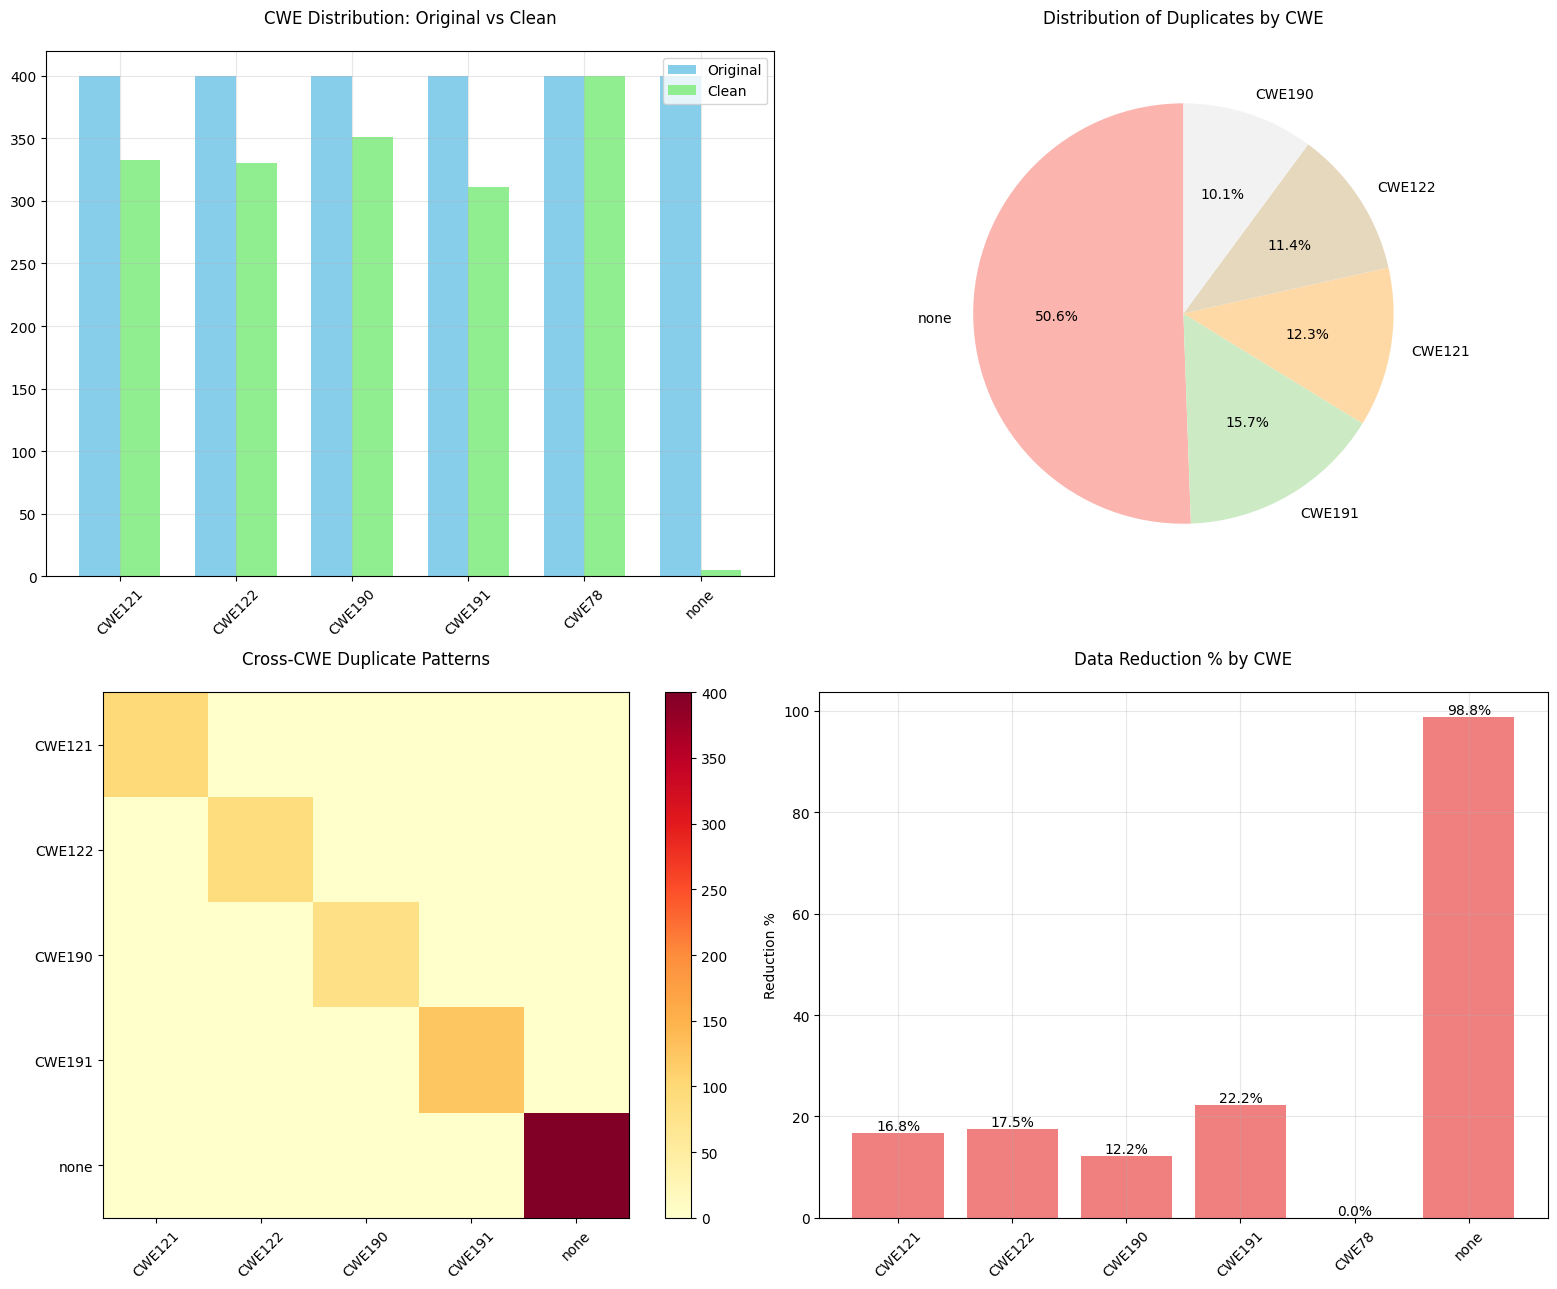


Cleaning Impact Statistics:
-------------------------
        Original  Clean  Reduction %
cwe                                 
CWE121       400    333        16.75
CWE122       400    330        17.50
CWE190       400    351        12.25
CWE191       400    311        22.25
CWE78        400    400         0.00
none         400      5        98.75


In [22]:
impact_stats = visualize_data_quality(df, df_clean)
print("\nCleaning Impact Statistics:")
print("-------------------------")
print(impact_stats.round(2))